# __Time Series Forecasting__

Time series forecasting is the practice of predicting unknown values over time. This process entails gathering historical data, preparing it for algorithmic analysis, and subsequently making predictions about future values based on patterns discerned from the historical dataset.

Various factors drive the interest of companies in forecasting future values, encompassing metrics such as GDP, monthly sales, inventory levels, unemployment rates, and global temperatures. For instance:

- Retailers may seek to predict future sales at the level of individual stock keeping units (SKUs) to facilitate planning and budgeting.
- Small merchants may aim to forecast sales by store, enabling them to allocate resources appropriately, such as scheduling more personnel during peak periods and fewer during slower times.
- Large technology companies like Google might be interested in determining the busiest hour of the day or the peak day of the week to optimize the allocation of server resources.
- Health departments may engage in predicting cumulative COVID vaccinations administered to anticipate when herd immunity is likely to be achieved."

How it works: 
 - Analyze trends, seasonality, and patterns in historical data.
 - Use statistical or machine learning models to predict future values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# __1 <span style='color:#F1C40F'>|</span> Data collection and preprocessing__

In [2]:
# Load historical prices of different vegetables and fruits in Nepal
vegetables_prices_df = pd.read_csv("./datasets/nepal_vegetables_prices.csv", parse_dates=["Date"], index_col="Date")
vegetables_prices_df.head(15)

,SN,Commodity,Unit,Minimum,Maximum,Average
Date,,,,,,
2013-06-16,0,Tomato Big(Nepali),Kg,35.0,40.0,37.5
2013-06-16,1,Tomato Small(Local),Kg,26.0,32.0,29.0
2013-06-16,2,Potato Red,Kg,20.0,21.0,20.5
2013-06-16,3,Potato White,Kg,15.0,16.0,15.5
2013-06-16,4,Onion Dry (Indian),Kg,28.0,30.0,29.0
2013-06-16,5,Carrot(Local),Kg,30.0,35.0,32.5
2013-06-16,6,Cabbage(Local),Kg,6.0,10.0,8.0
2013-06-16,7,Cauli Local,Kg,30.0,35.0,32.5
2013-06-16,8,Raddish Red,Kg,35.0,40.0,37.5


In [3]:
# Select specific commodity to forecast
commodity = "Green Peas"
daily_observations_avg = vegetables_prices_df[vegetables_prices_df["Commodity"] == commodity]["Average"]
daily_observations_avg.head(15)

Date
2013-06-16     57.5
2013-06-17     57.5
2013-06-18     57.5
2013-06-19     57.5
2013-06-20     57.5
2013-06-21     57.5
2013-06-25     57.5
2013-06-26     57.5
2013-07-22    135.0
2013-07-25    145.0
2013-07-26    145.0
2013-07-28    135.0
2013-08-02     95.0
2013-10-01    155.0
2013-10-02    130.0
Name: Average, dtype: float64

<Axes: title={'center': 'Daily prices of Green Peas in Nepal (Average price)'}, xlabel='Date'>

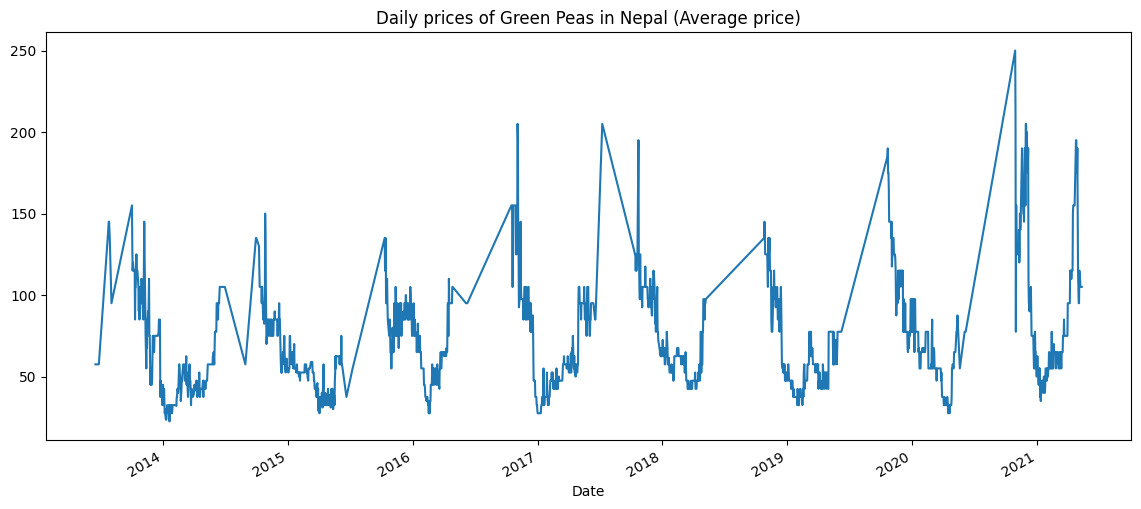

In [4]:
# Visualize raw data
daily_observations_avg.plot(
    figsize=(14, 6), 
    title=f"Daily prices of Green Peas in Nepal (Average price)"
)

#### __Drop data points with duplicate timestamps__

In [5]:
daily_observations_avg = daily_observations_avg[~daily_observations_avg.index.duplicated(keep='first')]

#### __Fill missing data points__
High-quality forecasts need clean, well-prepared data. Replace missing values using imputation methods suited for time data: forward/backward filling, interplation, etc.

In [6]:
# Generate missing timestamps: reindex the entire time series on full date range from min to max date in case some timestamps are misssing
full_date_range = pd.date_range(start=daily_observations_avg.index.min(), end=daily_observations_avg.index.max(), freq='D')
daily_observations_avg = daily_observations_avg.reindex(full_date_range)
print(f"Total missing values of the target variable: {daily_observations_avg.isna().sum()}")

Total missing values of the target variable: 1204


In [7]:
# Linearly interpolate missing values of the target variable
daily_observations_avg = daily_observations_avg.interpolate(method="linear")

# === Alternatively, you can try to apply other imputation methods ===
# daily_observations_avg = daily_observations_avg.ffill() # Backward fill
# daily_observations_avg = daily_observations_avg.bfill() # Forawrd fill
# daily_observations_avg = daily_observations_avg.fillna(daily_observations_avg.mean()) # Replace with a mean value

print(f"Total missing values of the target variable: {daily_observations_avg.isna().sum()}")

Total missing values of the target variable: 0


#### __Resample time series (if needed)__
Adjust the original time series to a desired time frequency

In [8]:
# Resample data to monthly time granularity
monthly_observations_avg = daily_observations_avg.resample('M').mean() # Aggregate by averaging daily data points 
monthly_observations_avg.tail(15)

/tmp/ipykernel_28320/4094793895.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_observations_avg = daily_observations_avg.resample('M').mean() # Aggregate by averaging daily data points


2020-03-31     54.919355
2020-04-30     35.416667
2020-05-31     67.085253
2020-06-30     88.123399
2020-07-31    123.896552
2020-08-31    160.775862
2020-09-30    197.060345
2020-10-31    232.016129
2020-11-30    148.833333
2020-12-31    104.112903
2021-01-31     47.983871
2021-02-28     59.464286
2021-03-31     67.862903
2021-04-30    134.500000
2021-05-31    109.615385
Freq: ME, Name: Average, dtype: float64

<Axes: title={'center': 'Monthly prices of Green Peas in Nepal (Average price)'}>

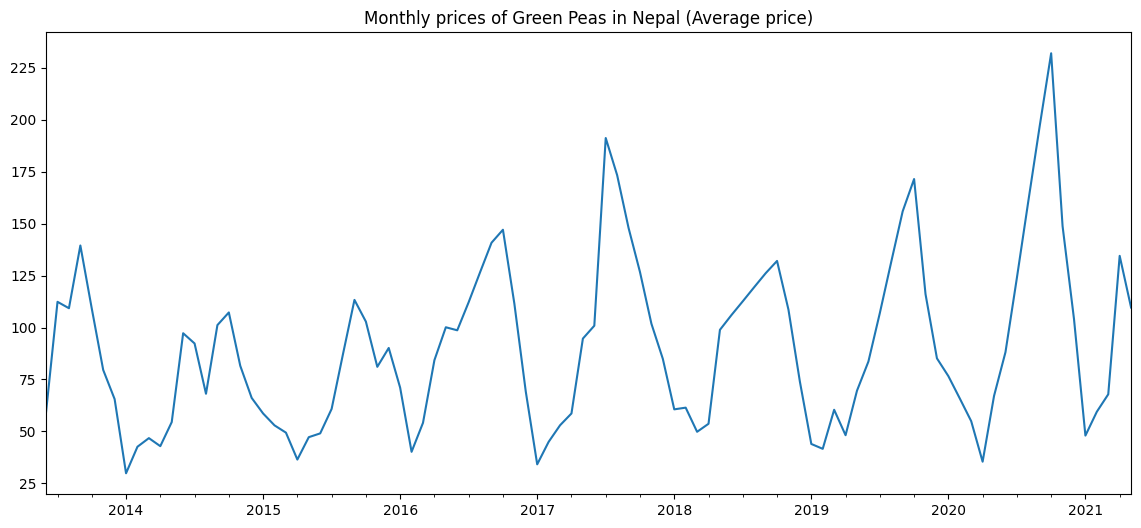

In [9]:
# Visualize monthly-resampled data
monthly_observations_avg.plot(
    figsize=(14, 6), 
    title=f"Monthly prices of Green Peas in Nepal (Average price)"
)

# __2 <span style='color:#F1C40F'>|</span> Perform EDA: Analyze trend, seasonality, cyclicity, residual. Check for stationarity__

### __Trend__
Trend represents the long-term change in the level of a time series. This change can be either upward (increase in level) or downward (decrease in level). Typically can be computed by applying a smoothing technique on the raw data (for example, using a Moving Average)

### __Seasonality__
Seasonality in time series analysis refers to the short-term repetitive and predictable patterns or fluctuations in data that occur at regular intervals, often corresponding to specific time periods such as days, months, or years. Can be computed by grouping and aggregating data points based on predefined seasonal period

### __Cyclicity__
Fluctuations that occur at irregular intervals and are typically influenced by economic or natural cycles. 

### __Residual (Noise)__
Short-term random variation or "noise" that cannot be attributed to trend, seasonality, or cycles. Can be computed by subtracting (or dividing, in case of multiplicative model) trend and seasonal components from the original observed data.

![Time Series properties](./img/time-series-components.png)

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

Decompose each component and visualize it

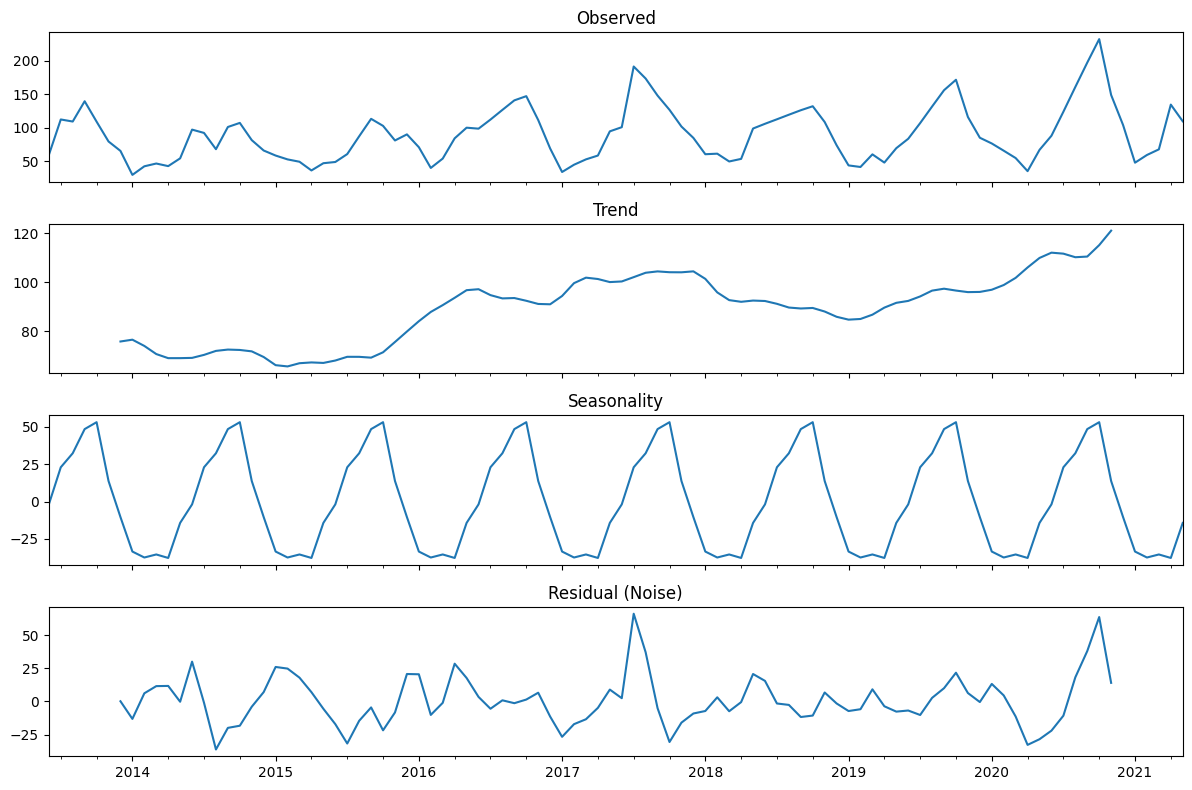

In [11]:
decomposition = seasonal_decompose(monthly_observations_avg, model='additive', period=12)  # monthly data with yearly seasonality

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residual (Noise)')
plt.tight_layout()

plt.show()

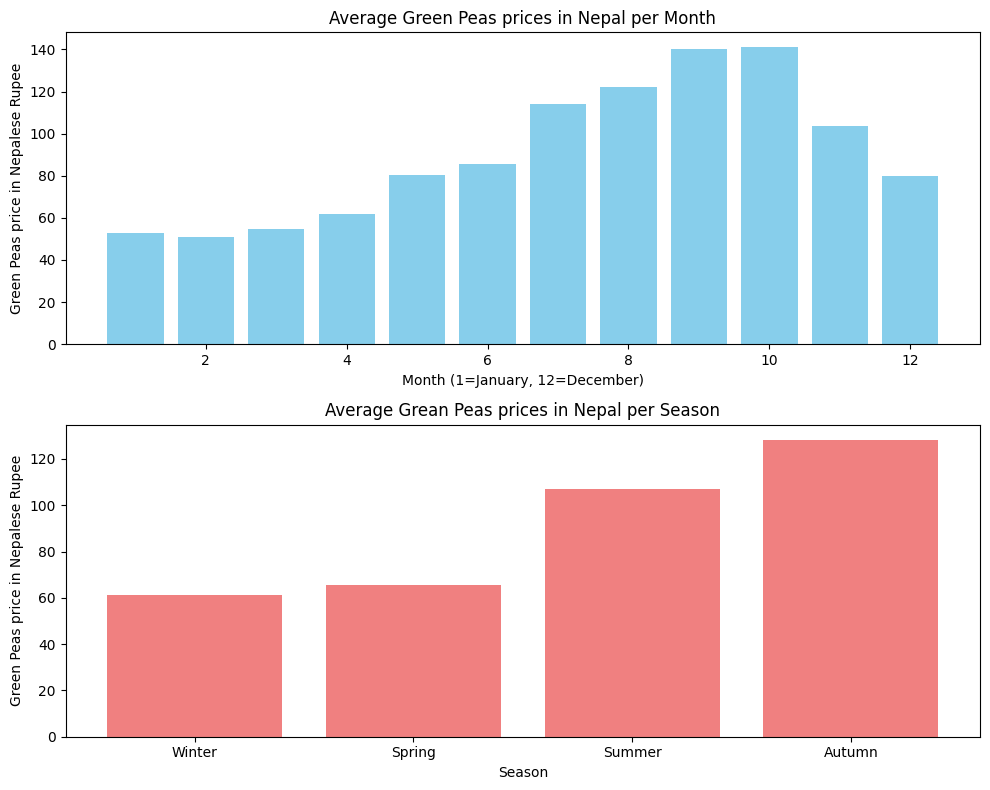

In [14]:
monthly_totals = monthly_observations_avg.groupby(monthly_observations_avg.index.month).mean()

seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}
# Calculating average prices per season
seasonal_totals = {
    season: monthly_totals.loc[monthly_totals.index.isin(months)].mean()
    for season, months in seasons.items()
}


fig, axes = plt.subplots(2, 1, figsize=(10, 8), tight_layout=True)

# Show average Green Peas prices per individual months
axes[0].bar(monthly_totals.index, monthly_totals.values, color='skyblue')
axes[0].set_title('Average Green Peas prices in Nepal per Month')
axes[0].set_xlabel('Month (1=January, 12=December)')
axes[0].set_ylabel('Green Peas price in Nepalese Rupee')


# Average Green Peas prices per Season
axes[1].bar(seasonal_totals.keys(), seasonal_totals.values(), color='lightcoral')
axes[1].set_title('Average Grean Peas prices in Nepal per Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Green Peas price in Nepalese Rupee')

plt.show()

In [15]:
# Descriptive statistics
monthly_observations_avg.describe()

count     96.000000
mean      90.565700
std       40.590572
min       29.838710
25%       58.632258
50%       85.040323
75%      112.249253
max      232.016129
Name: Average, dtype: float64

## __Stationarity__

A time series is said to be stationary when its statistical properties (mean, variance) are constant and don't change over time. As a result, stationary time series don't exhibit trend and seasonlity. However, even though most of the popular TS algorithms can handle non-stationary series, some require them to be stationary, so it's important to apply transformations.

![Time Series Stationarity](./img/stationarity.jpg)

### __Check for stationarity__

In order to ensure a time series is stationary, we can use a statisitcal test, for example, the Dickey-Fuller, which is the most popular one. This test checks for the presence of a unit root, which indicates non-stationarity.

- If __p-value__ < 0.05 → reject __H₀__ → likely stationary
- If __p-value__ ≥ 0.05 → fail to reject __H₀__ → likely non-stationary

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def adf_stationarity_test(time_series: pd.Series):
    """Checks if time series is stationary based on ADF test"""

    adf_result = adfuller(time_series)
    p_value = adf_result[1]
    print(f"p_value: {p_value}")

    if p_value < 0.05:
        return True # Reject the null hypothesis: The time series is stationary.
    
    return False # Fail to reject the null hypothesis: The time series is non-stationary.

In [18]:
is_stationary = adf_stationarity_test(monthly_observations_avg)
is_stationary

p_value: 0.9137191953321615


False

### __How to make non-stationary series stationary?__
Apply differencing to make the series stationary: $y_t' = y_t - y_{t-1}$

In [19]:
differenced = monthly_observations_avg.diff().dropna()
differenced.head(10)

2013-07-31    52.881927
2013-08-31    -3.078784
2013-09-30    30.209677
2013-10-31   -30.387097
2013-11-30   -29.529570
2013-12-31   -14.043011
2014-01-31   -35.701613
2014-02-28    12.777362
2014-03-31     4.141993
2014-04-30    -3.866398
Freq: ME, Name: Average, dtype: float64

# __3 <span style='color:#F1C40F'>|</span> Build a Predictive Model__

In [21]:
# Import regression metrics to evaluate TS forecast
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [22]:
# === Utils ===

def calculate_metrics(test_series: pd.Series, forecast_series: pd.Series):
    """
    Calculate metrics for the forecasted values
    
    Args:
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values

    Returns:
        - mape: Mean Absolute Percentage Error between test vs forecast
        - mae: Mean Absolute Error between test vs forecast 
        - mse: Mean Squared Error between test vs forecast 
    """

    mape = mean_absolute_percentage_error(test_series, forecast_series)
    mae = mean_absolute_error(test_series, forecast_series)
    mse = mean_squared_error(test_series, forecast_series)

    return mape, mae, mse


def visualize_forecast(
    train_series: pd.Series,
    test_series: pd.Series, 
    forecast_series: pd.Series,
    title: str="Forecasting predictions"
):
    """
    Visualize forecasting predictions with metrics
    
    Args:
        train_series (pd.Series): Historircal time series
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values
        title (str): Plot title
    """

    # Calculate metrics
    mape, mae, mse = calculate_metrics(test_series, forecast_series)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot each series
    train_series.plot(ax=ax, label="Train series")
    test_series.plot(ax=ax, label="Test Series")
    forecast_series.plot(ax=ax, label="Predicted Series")
    
    # Plotting titles and labels
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Forecast results")
    ax.grid(True)
    ax.legend(title="Series")

    # Add the metrics as text on the plot
    metrics_text = f"MAPE: {mape:.2f}%\nMAE: {mae:.2f}\nMSE: {mse:.2f}"
    ax.text(0.99, 0.95, metrics_text, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()

Train-test split

In [23]:
test_size = 12 # use last 12 months as testing data
train_series, test_series = monthly_observations_avg[:-test_size], monthly_observations_avg[-test_size:]

In [24]:
len(train_series), len(test_series)

(84, 12)

## __SARIMA__
SARIMA (which stands for Seasonal Autoregressive Integrated Moving Average) is a popular statistical TS algorithm. Basically, it is the combination of simpler models that create a complex model that can present a time series exhibiting non-stationary properties and seasonality.

SARIMA consists of the following components (models):
- __AR(p)__: AR (Autoregression) model uses past values of the time series to predict the current value. Parameter __p__ represents the number of lag observations included in the model.
- __I(d)__: Integrated component. Parameter __d__  represents the number of times the raw observations are differenced to make the series stationary.
- __MA(q)__: MA (Moving Average) model uses past forecast errors to model the current value. Paraamter __q__ represents the number of lagged forecast errors in the prediction equation.
- __S(P, D, Q, s)__: Component used to handle seasonality. __P__, __D__, __Q__ are the same parameters as in the base model, but used for the seasonal component. __s__ represents seasonal period.

Good for predicting univariate series with a clear seasonal pattern and trend. But requires manual parameters tuning, and can be slow for large datasets.

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mango import scheduler, Tuner # pip install arm-mango

/home/sviatoslav/.pyenv/versions/3.11.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use Bayesian optimization to find best set of SARIMA parameters: (__p__, __d__, __q__, __P__, __D__, __Q__, __s__)

In [26]:
@scheduler.parallel(n_jobs=2)
def sarima_objective(**params):
    """Objective function to find best set of SARIMAX parameters"""

    p, d, q, P, D, Q, s = int(params['p']), int(params['d']), int(params['q']), \
                        int(params['P']), int(params['D']), int(params['Q']), int(params['s'])
    
    try:
        model = SARIMAX(train_series, 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        aic = results.aic # Minimize AIC to find the best model
    except:
        aic = np.inf

    return aic

In [27]:
# Define the search space
sarimax_param_space = {
    'p': range(0, 3),
    'd': [1], # Use only first-order differencing
    'q': range(0, 3),
    'P': range(0, 3),
    'D': [1], # Use only first-order differencing
    'Q': range(0, 3),
    's': [12]  # Assume yearly seasonality
}

In [28]:
# Find best set of SARIMA's hyperparameters
tuner = Tuner(sarimax_param_space, objective=sarima_objective, conf_dict={"num_iteration": 10})
tuning_results = tuner.minimize()
best_params = tuning_results["best_params"]
best_params

/home/sviatoslav/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  0%|          | 0/10 [00:00<?, ?it/s]/home/sviatoslav/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/sviatoslav/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
Be

{'D': 1, 'P': 1, 'Q': 2, 'd': 1, 'p': 1, 'q': 2, 's': 12}

In [29]:
order = (
    best_params["p"],
    best_params["d"],
    best_params["q"],
)

seasonal_order = (
    best_params["P"],
    best_params["D"],
    best_params["Q"],
    best_params["s"],
)

model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

In [30]:
forecast_series = results.forecast(steps=len(test_series))
forecast_series

2020-06-30     92.591950
2020-07-31    126.214330
2020-08-31    134.057306
2020-09-30    151.365794
2020-10-31    149.029084
2020-11-30    115.344588
2020-12-31     94.017894
2021-01-31     72.745679
2021-02-28     68.411932
2021-03-31     68.920982
2021-04-30     65.528794
2021-05-31     89.824806
Freq: ME, Name: predicted_mean, dtype: float64

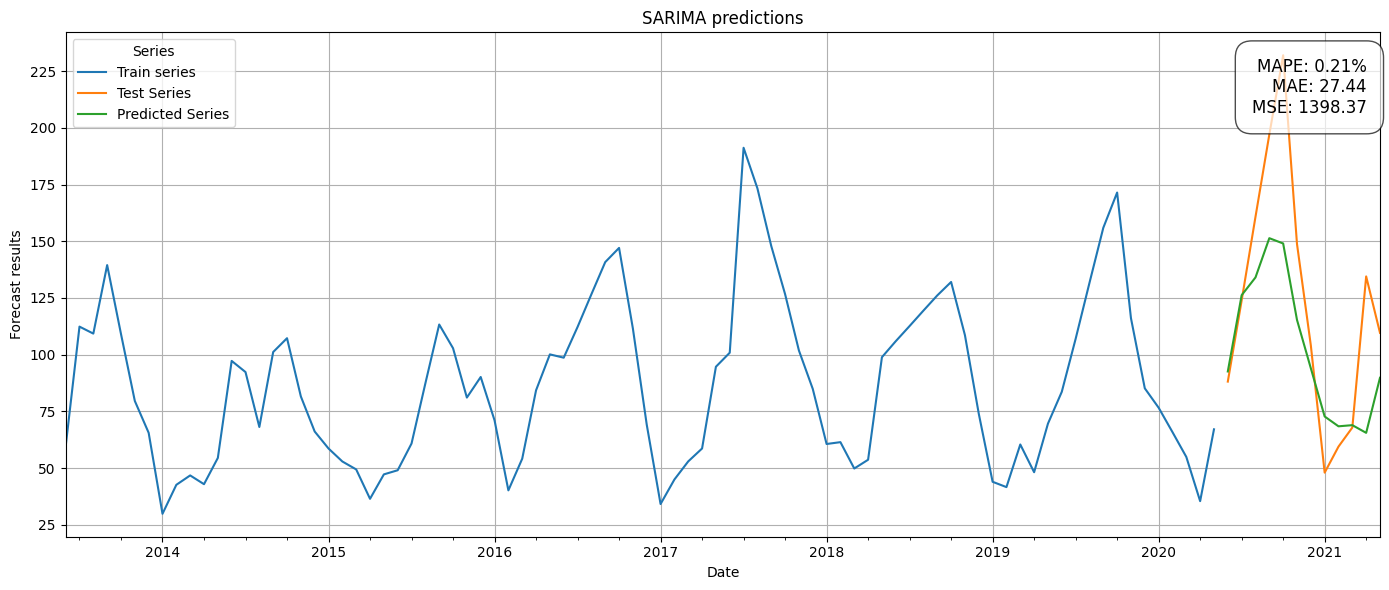

In [31]:
visualize_forecast(
    train_series,
    test_series,
    forecast_series,
    title="SARIMA predictions"
)

## __Prophet__
Prophet is another popular statistical forecasting model developed by Facebook designed to be simple yet powerful for business forecasting. 

It is fast and especially useful for data with strong seasonal patterns and outliers. However, It may underperform on highly complex patterns or when fine control over model structure is needed. 

In [32]:
from prophet import Prophet

In [33]:
# Note: Prophet requires train_df in format: {"ds": <timestamps>, "y": <target_variable>}
train_df_prophet = pd.DataFrame({
    'ds': train_series.index, 
    'y': train_series.values 
})

In [34]:
model = Prophet()
model.fit(train_df_prophet)

11:41:26 - cmdstanpy - INFO - Chain [1] start processing


11:41:27 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Create future dataframe
future_df = model.make_future_dataframe(periods=len(test_series), include_history=False, freq='M') 
future_df

,ds
0,2020-06-30
1,2020-07-31
2,2020-08-31
3,2020-09-30
4,2020-10-31
5,2020-11-30
6,2020-12-31
7,2021-01-31
8,2021-02-28
9,2021-03-31


In [36]:
forecast = model.predict(future_df)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-30,103.561675,73.232970,119.882636,103.561653,103.561694,-7.779688,-7.779688,-7.779688,-7.779688,-7.779688,-7.779688,0.0,0.0,0.0,95.781987
1,2020-07-31,103.925347,121.189878,165.101423,103.925249,103.925439,37.285827,37.285827,37.285827,37.285827,37.285827,37.285827,0.0,0.0,0.0,141.211174
2,2020-08-31,104.289019,109.375513,158.933306,104.288788,104.289204,30.114332,30.114332,30.114332,30.114332,30.114332,30.114332,0.0,0.0,0.0,134.403351
3,2020-09-30,104.640960,122.499049,170.031256,104.640563,104.641274,39.515556,39.515556,39.515556,39.515556,39.515556,39.515556,0.0,0.0,0.0,144.156517
4,2020-10-31,105.004633,117.157474,163.500518,105.004034,105.005093,35.030095,35.030095,35.030095,35.030095,35.030095,35.030095,0.0,0.0,0.0,140.034728
5,2020-11-30,105.356574,97.533003,143.336090,105.355789,105.357197,15.793404,15.793404,15.793404,15.793404,15.793404,15.793404,0.0,0.0,0.0,121.149977
6,2020-12-31,105.720246,70.872064,117.995704,105.719207,105.721126,-10.489325,-10.489325,-10.489325,-10.489325,-10.489325,-10.489325,0.0,0.0,0.0,95.230921
7,2021-01-31,106.083918,41.007686,85.199282,106.082639,106.085101,-42.796796,-42.796796,-42.796796,-42.796796,-42.796796,-42.796796,0.0,0.0,0.0,63.287122
8,2021-02-28,106.412396,46.600691,90.560730,106.410808,106.413784,-37.315737,-37.315737,-37.315737,-37.315737,-37.315737,-37.315737,0.0,0.0,0.0,69.096659
9,2021-03-31,106.776069,46.462512,93.013728,106.774176,106.777681,-37.637492,-37.637492,-37.637492,-37.637492,-37.637492,-37.637492,0.0,0.0,0.0,69.138576


In [37]:
forecast_series = forecast.set_index('ds')['yhat']

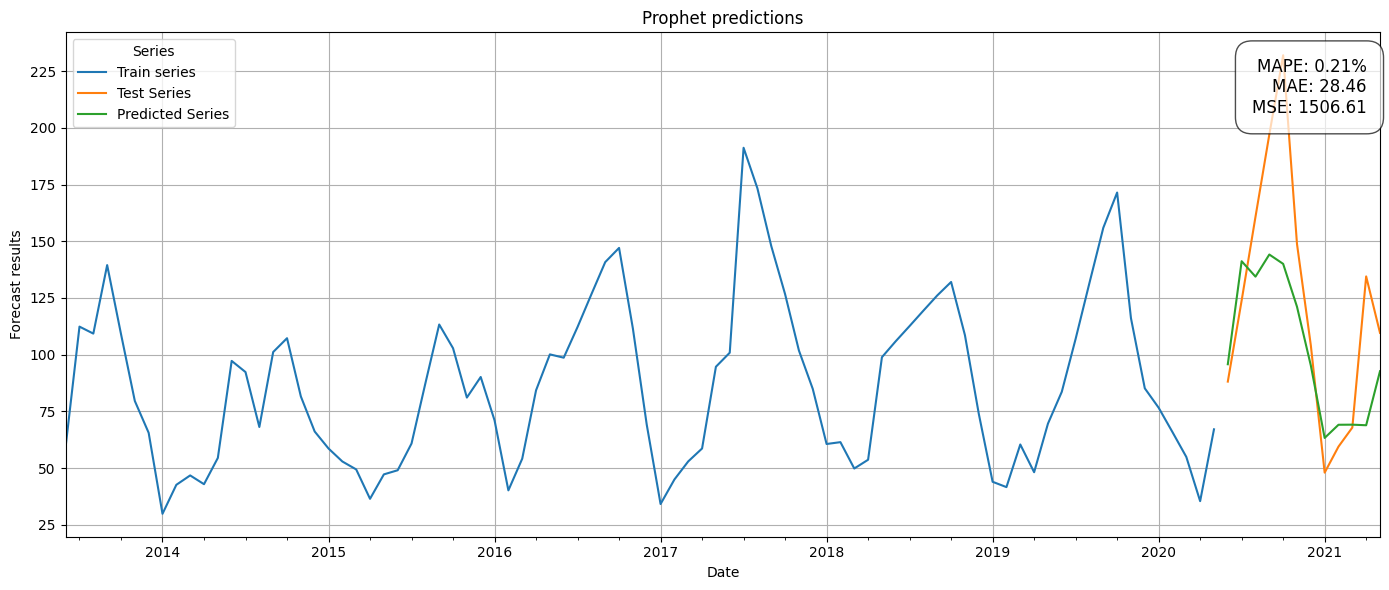

In [38]:
visualize_forecast(
    train_series=train_series,
    test_series=test_series,
    forecast_series=forecast_series,
    title="Prophet predictions"
)

## __Time-lagged regression model__
This approach involves using an ML Regression model (e.g XGBoost, Linear Regression) that learns to predict future value of the target variable based on last "n" observations passed as input features for the model.

A time-lagged regression model can be a better choice when the forecasting depends more on lagged inputs and external variables than on seasonal or structural time patterns.

In [39]:
from xgboost import XGBRegressor

In [40]:
def create_lag_features(time_series: pd.Series, lags=12):
    """Create time-lagged features for the provided time series"""

    df = pd.DataFrame(time_series)

    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df.iloc[:, 0].shift(i)
    
    return df

In [41]:
lags = 12 # Experiment with number of lags to improve model accuracy
time_lagged_df = create_lag_features(monthly_observations_avg, lags)
time_lagged_df = time_lagged_df.dropna() # Remove rows with NaN values after applying shifting
time_lagged_df.tail(10)

,Average,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
2020-08-31,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069,76.612903,85.161290,116.083333,171.485663,155.935185,131.648148
2020-09-30,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069,76.612903,85.161290,116.083333,171.485663,155.935185
2020-10-31,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069,76.612903,85.161290,116.083333,171.485663
2020-11-30,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069,76.612903,85.161290,116.083333
2020-12-31,104.112903,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069,76.612903,85.161290
2021-01-31,47.983871,104.112903,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069,76.612903
2021-02-28,59.464286,47.983871,104.112903,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355,65.862069
2021-03-31,67.862903,59.464286,47.983871,104.112903,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667,54.919355
2021-04-30,134.500000,67.862903,59.464286,47.983871,104.112903,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253,35.416667
2021-05-31,109.615385,134.500000,67.862903,59.464286,47.983871,104.112903,148.833333,232.016129,197.060345,160.775862,123.896552,88.123399,67.085253


In [42]:
train_df, test_df = time_lagged_df[:-test_size], time_lagged_df[-test_size:]

In [43]:
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [44]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
# Iteratevely make predictions: use previous predictions as input for the new one
y_pred = []
current_input = X_test.iloc[0].values.reshape(1, -1)

for _ in range(len(y_test)):
    prediction = model.predict(current_input)[0]
    y_pred.append(prediction)

    # Slide the window: Remove the oldest lag, add the latest prediction
    current_input = pd.concat([pd.Series([prediction]), pd.Series(current_input[0][:-1])]).values.reshape(1, -1)

In [46]:
len(y_pred)

12

In [47]:
forecast_series = pd.Series(y_pred, index=test_series.index)
forecast_series

2020-06-30     93.541656
2020-07-31     97.293526
2020-08-31     98.021584
2020-09-30    111.128029
2020-10-31    154.106094
2020-11-30    147.048370
2020-12-31    112.605637
2021-01-31     85.572227
2021-02-28     71.921806
2021-03-31     49.341961
2021-04-30     63.675652
2021-05-31     39.088646
Freq: ME, dtype: float32

In [48]:
len(test_series), len(forecast_series)

(12, 12)

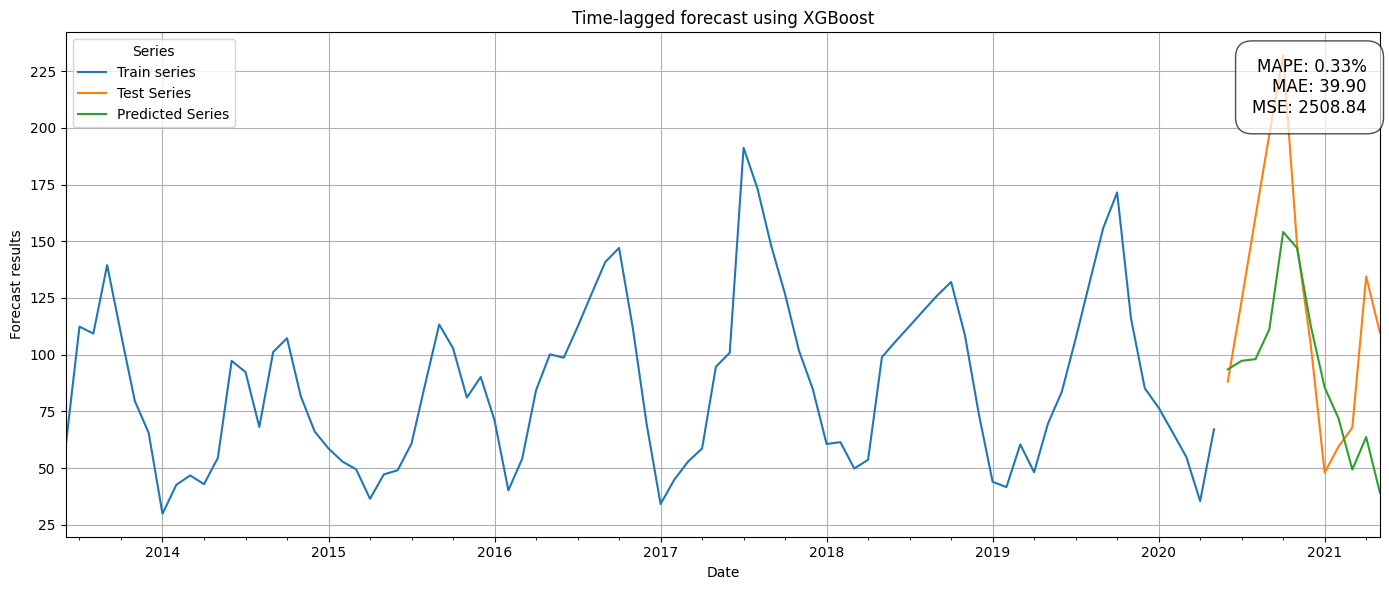

In [49]:
visualize_forecast(
    train_series,
    test_series,
    forecast_series,
    title="Time-lagged forecast using XGBoost"
)

## __Amazon Chronos Bolt (pretrained)__
Unlike the above models, Chronos-Bolt is a pre-trained time series forecasting model (trained on nearly 100 billion time series observations). It is a transformer-based model (particularly, it's based on T5 encoder-decoder architecture) that can be used for efficient zero-shot forecasting.

In [50]:
import torch
from chronos import BaseChronosPipeline # pip install chronos-forecasting

In [51]:
chronos_model = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [52]:
train_values = torch.tensor(train_series)
forecast = chronos_model.predict_quantiles(
    context=train_values,
    prediction_length=len(test_series)
)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [53]:
mean_forecast = forecast[1][0].tolist() # Target predictions (mean)
forecast_series = pd.Series(mean_forecast, index=test_series.index)
forecast_series.tail(10)

2020-08-31    112.867020
2020-09-30    123.520447
2020-10-31    122.399033
2020-11-30    101.582802
2020-12-31     72.355972
2021-01-31     50.067890
2021-02-28     44.460823
2021-03-31     45.582237
2021-04-30     49.787537
2021-05-31     63.104317
Freq: ME, dtype: float64

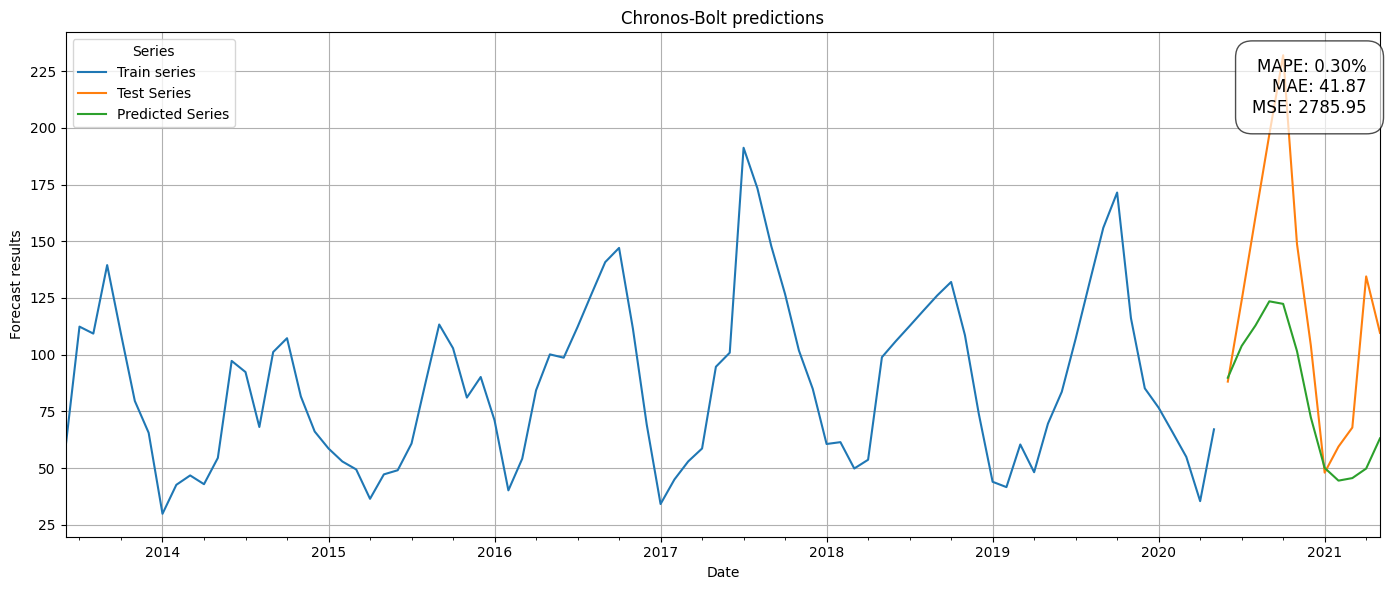

In [54]:
visualize_forecast(
    train_series=train_series,
    test_series=test_series,
    forecast_series=forecast_series,
    title="Chronos-Bolt predictions"
)

# __Hometask__

- Load historical Electricity Consumption data in Romania (`./datasets/electricity_consumption_and_production.csv`).
- Perform EDA of the data. Analyze trend and seasonality (Use `Consumption` column as the target variable).
- Train Time Series models to predict Electricty Consumption volumes 15, 30, 45 days ahead (Note that the data contains hourly observations). Run forecast using the 4 models described in the lecture (SARIMAX, Prophet, Time-lagged Regression model, Chronos-Bolt). Conclude which model is the most effective for this dataset (in terms of both training/inference speed and predictions accuracy).
- Visualize predictions for each model and provide metrics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
import torch
from chronos import BaseChronosPipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [5]:
df = pd.read_csv("./datasets/electricity_consumption_and_production.csv", index_col="DateTime")

In [6]:
df

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...
2025-03-19 19:00:00,8027,6177,1367,593,1922,1217,978,0,71
2025-03-19 20:00:00,7939,6228,1376,647,1920,1223,965,0,71
2025-03-19 21:00:00,7553,6120,1376,671,1881,1171,949,0,69


In [7]:
y = df['Consumption']

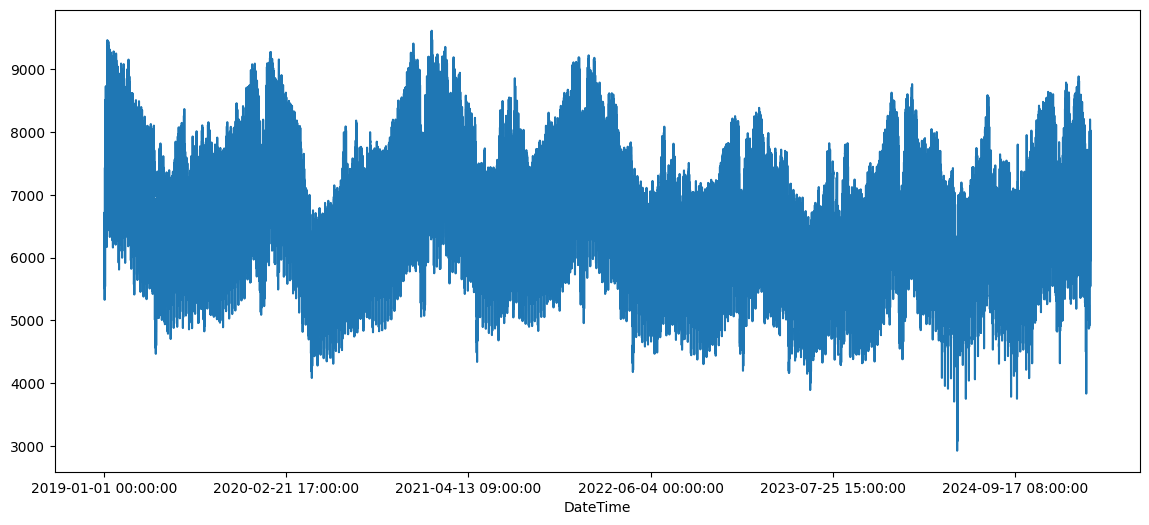

In [10]:
y.plot(figsize=(14, 6))
plt.show()

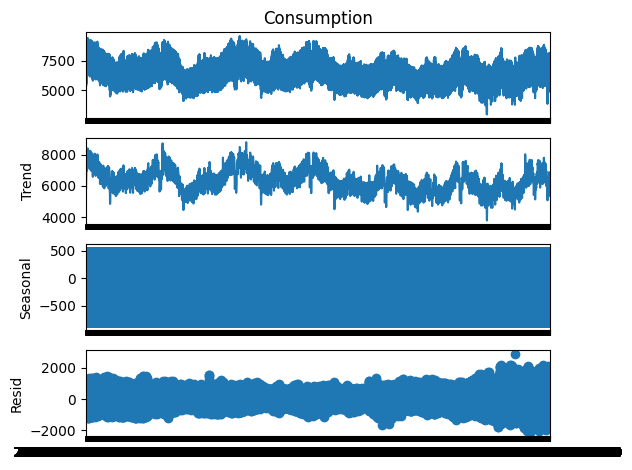

In [ ]:

decomposition = seasonal_decompose(y, model='additive', period=24)  
decomposition.plot()
plt.show()

In [ ]:
test_size = 24 * 15  
train_series, test_series = y[:-test_size], y[-test_size:]

In [ ]:
sarima_model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_results = sarima_model.fit(disp=False)
sarima_forecast = sarima_results.forecast(steps=test_size)

c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

In [ ]:
train_df_prophet = pd.DataFrame({'ds': train_series.index, 'y': train_series.values})
model_prophet = Prophet()
model_prophet.fit(train_df_prophet)
future_df = model_prophet.make_future_dataframe(periods=test_size, freq='H', include_history=False)
forecast_prophet = model_prophet.predict(future_df)
prophet_forecast = forecast_prophet.set_index('ds')['yhat']

c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
20:58:49 - cmdstanpy - INFO - Chain [1] start processing
20:59:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
####

def create_lag_features(series, lags=24):
    df_lag = pd.DataFrame(series)
    for i in range(1, lags+1):
        df_lag[f'lag_{i}'] = df_lag.iloc[:, 0].shift(i)
    return df_lag.dropna()

In [21]:
lags = 24
lagged_df = create_lag_features(y, lags)
train_df, test_df = lagged_df[:-test_size], lagged_df[-test_size:]
X_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
X_test, y_test = test_df.iloc[:, 1:], test_df.iloc[:, 0]

In [32]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-02 01:00:00,5647.0,5936.0,6222.0,6441.0,6632.0,6718.0,6613.0,6009.0,5813.0,5710.0,...,5617.0,5510.0,5524.0,5513.0,5525.0,5557.0,5682.0,5873.0,6116.0,6352.0
2019-01-02 02:00:00,5500.0,5647.0,5936.0,6222.0,6441.0,6632.0,6718.0,6613.0,6009.0,5813.0,...,5643.0,5617.0,5510.0,5524.0,5513.0,5525.0,5557.0,5682.0,5873.0,6116.0
2019-01-02 03:00:00,5385.0,5500.0,5647.0,5936.0,6222.0,6441.0,6632.0,6718.0,6613.0,6009.0,...,5737.0,5643.0,5617.0,5510.0,5524.0,5513.0,5525.0,5557.0,5682.0,5873.0
2019-01-02 04:00:00,5327.0,5385.0,5500.0,5647.0,5936.0,6222.0,6441.0,6632.0,6718.0,6613.0,...,5776.0,5737.0,5643.0,5617.0,5510.0,5524.0,5513.0,5525.0,5557.0,5682.0
2019-01-02 05:00:00,5362.0,5327.0,5385.0,5500.0,5647.0,5936.0,6222.0,6441.0,6632.0,6718.0,...,5744.0,5776.0,5737.0,5643.0,5617.0,5510.0,5524.0,5513.0,5525.0,5557.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-04 00:00:00,6550.0,7108.0,7814.0,8073.0,8135.0,8210.0,7585.0,7026.0,6701.0,6750.0,...,7508.0,7713.0,7444.0,6550.0,5795.0,5505.0,5376.0,5573.0,5779.0,5978.0
2025-03-04 01:00:00,6292.0,6550.0,7108.0,7814.0,8073.0,8135.0,8210.0,7585.0,7026.0,6701.0,...,7002.0,7508.0,7713.0,7444.0,6550.0,5795.0,5505.0,5376.0,5573.0,5779.0
2025-03-04 02:00:00,6031.0,6292.0,6550.0,7108.0,7814.0,8073.0,8135.0,8210.0,7585.0,7026.0,...,6785.0,7002.0,7508.0,7713.0,7444.0,6550.0,5795.0,5505.0,5376.0,5573.0


In [22]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)
xgb_forecast_series = pd.Series(xgb_forecast, index=test_series.index)


In [ ]:
chronos_model = BaseChronosPipeline.from_pretrained("amazon/chronos-bolt-base", device_map="cpu", torch_dtype=torch.bfloat16)
train_values = torch.tensor(train_series.values)
chronos_forecast = chronos_model.predict_quantiles(context=train_values, prediction_length=test_size)
chronos_forecast_series = pd.Series(chronos_forecast[1][0].tolist(), index=test_series.index)


c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\maksi\.cache\huggingface\hub\models--amazon--chronos-bolt-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\chronos\chronos_

In [28]:
print(prophet_forecast.isna().sum())

18


In [29]:
prophet_forecast = prophet_forecast.fillna(method='ffill').fillna(method='bfill')

C:\Users\maksi\AppData\Local\Temp\ipykernel_10496\2990396983.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_forecast = prophet_forecast.fillna(method='ffill').fillna(method='bfill')


SARIMAX - MAPE: 0.20143746135613216, MAE: 1121.730072113731, MSE: 1880711.162897369


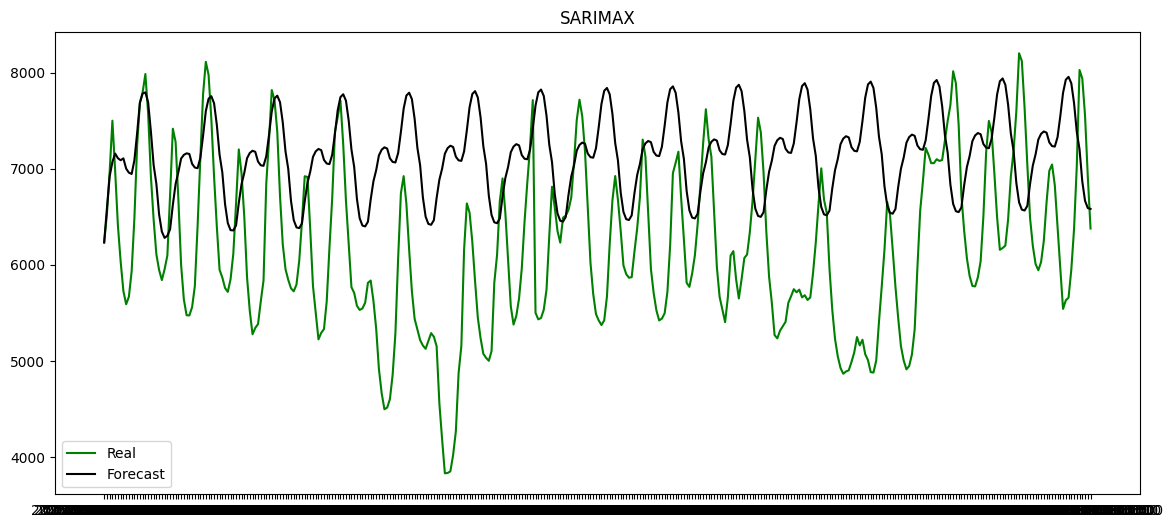

Prophet - MAPE: 0.10363939905861434, MAE: 591.153959271971, MSE: 695991.4643764497


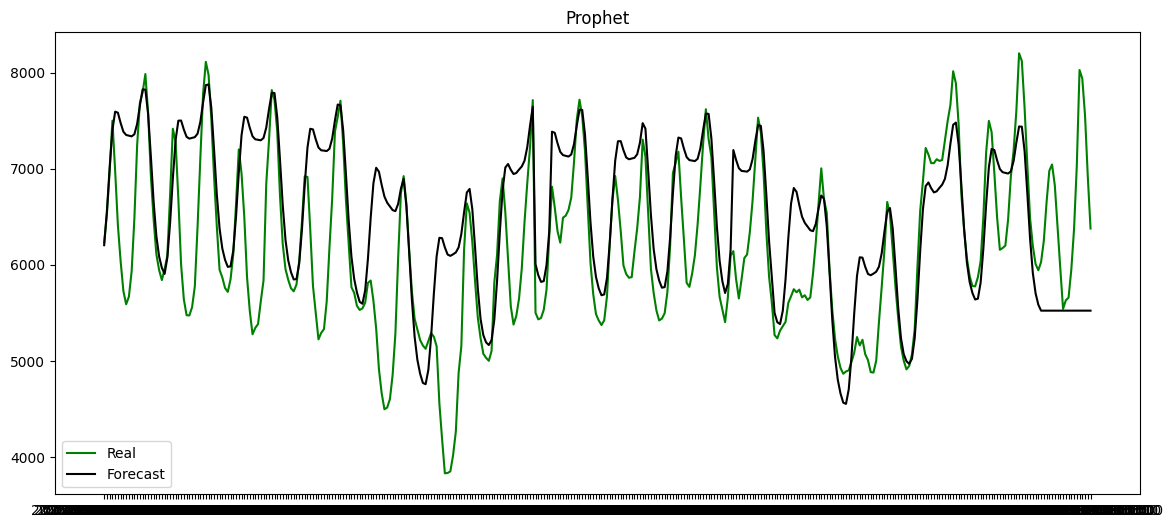

Time-lagged - MAPE: 0.02450760267674923, MAE: 151.79791259765625, MSE: 52549.25


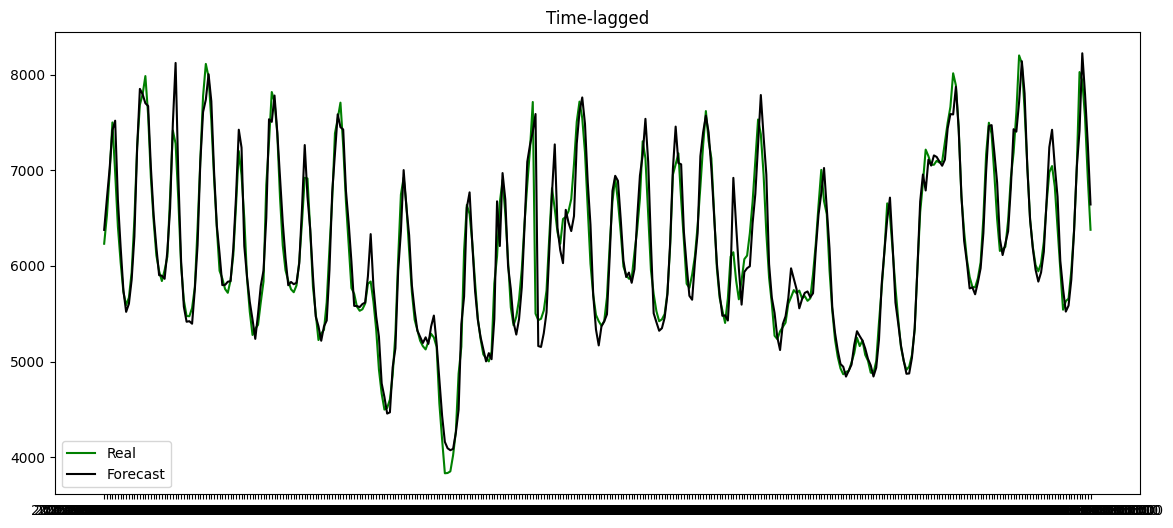

Chronos-Bolt - MAPE: 0.1632124255449326, MAE: 931.6812798394097, MSE: 1312154.927560148


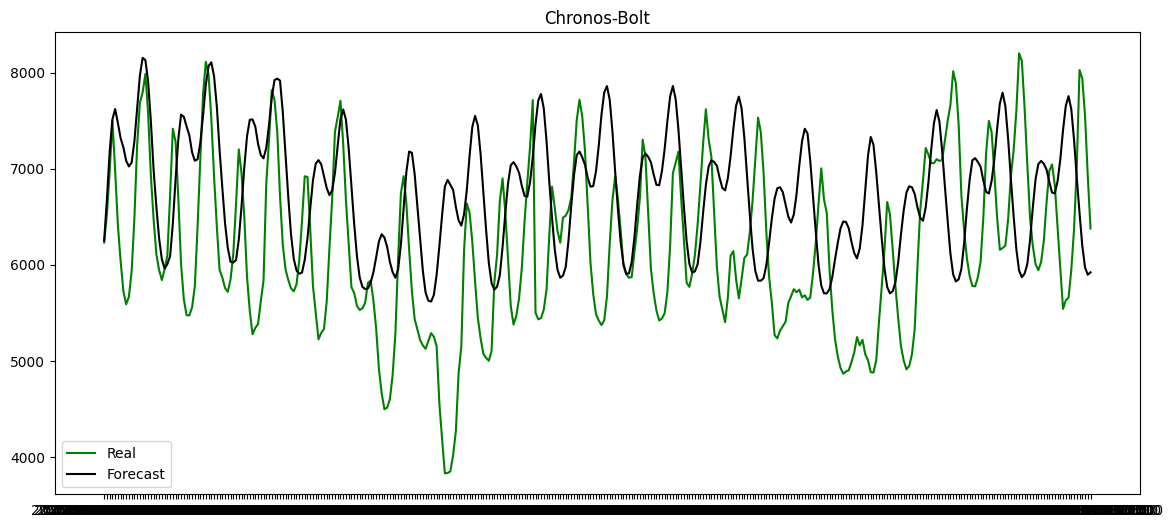

In [34]:

def show_metrics(true, pred, title):
    mape = mean_absolute_percentage_error(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    print(f"{title} - MAPE: {mape}, MAE: {mae}, MSE: {mse}")
    plt.figure(figsize=(14,6))
    plt.plot(true.index, true.values, label='Real', color = "green")
    plt.plot(true.index, pred.values, label='Forecast', color = "black" )
    plt.title(title)
    plt.legend()
    plt.show()



show_metrics(test_series, sarima_forecast, "SARIMAX")
show_metrics(test_series, prophet_forecast, "Prophet")
show_metrics(test_series, xgb_forecast_series, "Time-lagged")
show_metrics(test_series, chronos_forecast_series, "Chronos-Bolt")

DateTime
2025-03-04 05:00:00    6204.694062
2025-03-04 06:00:00    6560.153777
2025-03-04 07:00:00    7015.479987
2025-03-04 08:00:00    7403.287969
2025-03-04 09:00:00    7593.681928
                          ...     
2025-03-19 19:00:00            NaN
2025-03-19 20:00:00            NaN
2025-03-19 21:00:00            NaN
2025-03-19 22:00:00            NaN
2025-03-19 23:00:00            NaN
Name: yhat, Length: 360, dtype: float64

18
